In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import preprocessing
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import mlflow

import logging
import pickle

import sys
from datetime import datetime

# setting path
sys.path.append('../scripts')
from preprocessing_functions import weekends, time_of_month, label_holidays, days_from_holiday


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Dataset

In [2]:
logging.info('Load Training Set')

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
df_train = pd.read_csv('../data/train_clean.csv', na_values=['?', None, 'undefined'])
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,1,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,1,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,1,31,7,2015


In [4]:
logging.info('Load Test Set')

In [5]:
df_test = pd.read_csv('../data/test_clean.csv', na_values=['?', None, 'undefined'])
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,0,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,0,17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,0,17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,0,17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,0,17,9,2015


In [6]:
logging.info('Load Store Info')

In [7]:
df_store = pd.read_csv('../data/store.csv', na_values=['?', None, 'undefined'])
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Add some more features to dataset

In [8]:
df_train['Weekend'] = df_train['DayOfWeek'].apply(weekends)
df_test['Weekend'] = df_test['DayOfWeek'].apply(weekends)

df_train['TimeOfMonth'] = df_train['Day'].apply(time_of_month)
df_test['TimeOfMonth'] = df_test['Day'].apply(time_of_month)

df_train['Holiday'] = df_train['StateHoliday'].apply(label_holidays)
df_test['Holiday'] = df_test['StateHoliday'].apply(label_holidays)

df_train['Date'] = pd.DatetimeIndex(df_train['Date'])


In [9]:
df_weekends = df_train[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
df_weekends = df_weekends[df_weekends['Open'] == 1]
weekend_stores = df_weekends[['Store', 'DayOfWeek']].groupby('Store').nunique()
weekend_stores = weekend_stores[weekend_stores['DayOfWeek'] == 7].reset_index()
len(weekend_stores)

33

In [10]:
df_weekends = df_weekends[df_weekends['Store'].isin(set(weekend_stores['Store']))]
weekendstores = set(df_weekends['Store'])

def isallweekstore(x):
    if x in weekendstores:
        return 1
    return 0

df_train['7DayStore'] = df_train['Store'].apply(isallweekstore)

In [11]:

df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].max())
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

In [13]:

holidays = np.array(df_train[df_train["Holiday"] != 1]["Date"].unique())
holidays = np.sort(holidays)

df_train["TillHday"], df_train["AfterHday"] = days_from_holiday(df_train["Date"], holidays)


In [17]:
df_train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,TillHday,AfterHday
4751,292,1,2015-07-27,0,0,0,1,0,1,1,27,7,2015,0,2,0,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,14,53
400307,363,3,2014-07-09,6951,887,1,0,0,1,1,9,7,2014,0,0,0,a,a,250.0,9.0,2009.0,0,NaN,NaN,NaN,20,8
335727,292,2,2014-09-16,6925,836,1,1,0,0,0,16,9,2014,0,1,0,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,0,1
974257,533,5,2013-02-08,10110,886,1,1,0,0,1,8,2,2013,0,0,0,a,c,5950.0,NaN,NaN,0,NaN,NaN,NaN,33,49
570632,538,3,2014-02-05,4663,633,1,1,0,0,0,5,2,2014,0,0,0,a,a,990.0,2.0,2010.0,0,NaN,NaN,NaN,0,1


In [16]:
le = preprocessing.LabelEncoder()
df_train['StoreType'] = le.fit_transform(df_train['StoreType'])
df_train['Assortment'] = le.fit_transform(df_train['Assortment'])

df_test['StoreType'] = le.fit_transform(df_test['StoreType'])
df_test['Assortment'] = le.fit_transform(df_test['Assortment'])

In [17]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,0,2,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,0,0,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,0,2,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [18]:
# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]
    

# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]

In [19]:
# holidays = pd.Series(list(set(df_train[df_train['StateHoliday'] != '0']['Date'])))

In [25]:
x = df_train[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]
y_scaler = StandardScaler()
y = y_scaler.fit_transform(df_train[['Sales']].values)
train_features = x.columns
x = x.values

### Linear Regression Pipeline with 5 fold cross validation

In [26]:

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, reg_pipe.predict(X_test))
        print("r2_score:", score)
        print("mean squared error:", mse)
        #log model params
        mlflow.log_param("lin_reg_score", score)
        mlflow.log_param("lin_reg_mse", mse)
        # log model
        mlflow.sklearn.log_model(reg_pipe, "lin_regression_models")
        mlflow.end_run()

r2_score: 0.578577096228677
mean squared error: 0.42453021442689104
r2_score: 0.5448473375109157
mean squared error: 0.4692291514080986
r2_score: 0.5787470467493236
mean squared error: 0.4147636829326782
r2_score: 0.5285085086106526
mean squared error: 0.48316630810495154
r2_score: 0.5418011595138041
mean squared error: 0.4316170173107398


### Random Forest Regressor Pipeline with 5 fold cross validation

In [33]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 8, max_depth = 20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        print("score:", score)
        #log model params
        mlflow.log_param("rand_forest_reg_score", score)

        # log model
        mlflow.sklearn.log_model(forest_pipe, "random_forest_regression_models")
        mlflow.end_run()

score: 0.8981148916746698
score: 0.8808641762895018
score: 0.8976320477528086
score: 0.880901130985787
score: 0.8990287212853736


### Save Model

In [34]:
filename = '../models/forest-'+datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+f'-{datetime.now().microsecond}.sav'
pickle.dump(forest_pipe, open(filename, 'wb'))

In [35]:
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=20, n_estimators=8))])

### Feature importance

#### Linear Regression Model

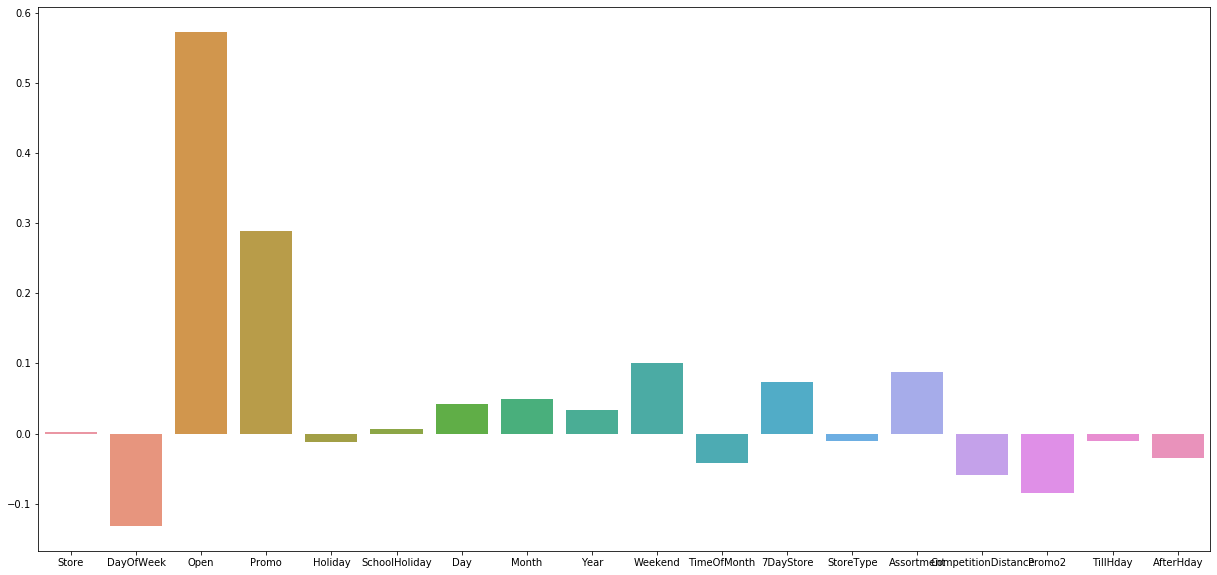

In [48]:
plt.figure(figsize=(21,10))
sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])

<h5> As Day of week, time of month, distance from competition, and Promo2 increase, the sales value decreases
The most important features are whether the store was open and whether the store ran a promo. </h5>

#### Random Forest Regression Model Feature Importance

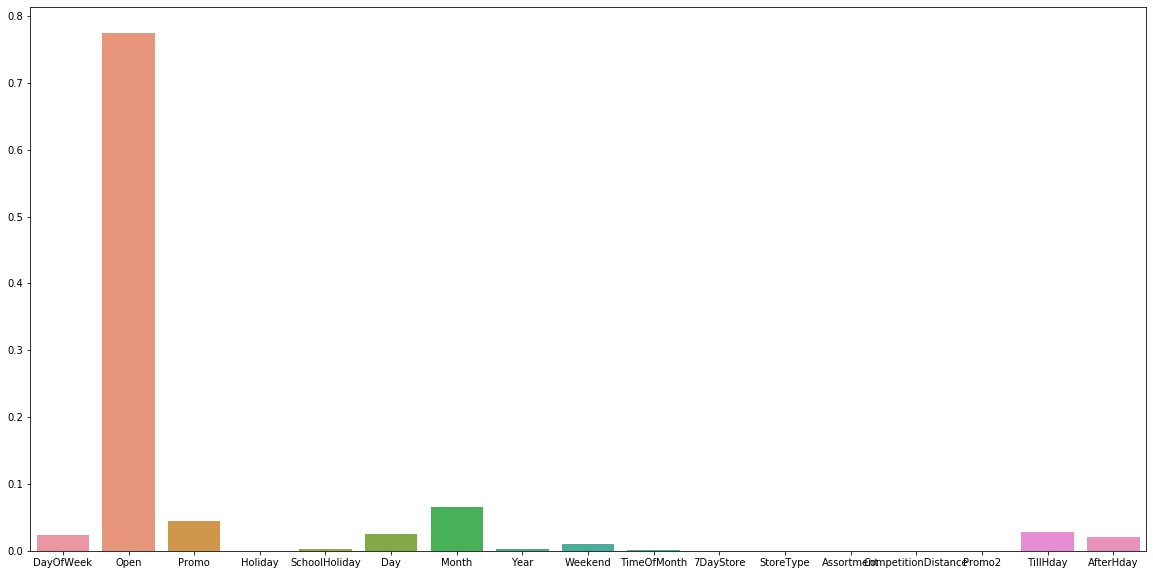

In [93]:
plt.figure(figsize=(20,10))
sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)

<h5> Here, the most important features are whether it's open, the store id, the competition distance, and whether a promo was done on that day or not <h5>